<a href="https://colab.research.google.com/github/kwsk01/machine_learning/blob/main/Bayes/%E7%B5%84%E3%81%BF%E5%90%88%E3%82%8F%E3%81%9B%E3%82%92%E8%80%83%E6%85%AE%E3%81%97%E3%81%9F%E7%B5%B1%E8%A8%88%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [75]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

In [76]:
n = [434,382,394,88]
clicks = [8,17,10,4]
#clicks/n = [0.018, 0.04, 0.025, 0.04]

# クリックの割合のみ考慮したモデル

$$
  \theta \sim Beta(1,1)\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """


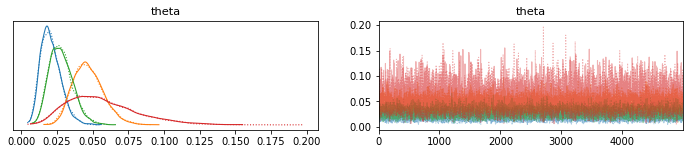

In [77]:
with pm.Model() as model:
  theta = pm.Beta('theta',alpha=1,beta=1,shape=len(n))
  obs = pm.Binomial('obs',p=theta, n=n, observed=clicks)
  trace = pm.sample(5000,chains=2)
  pm.traceplot(trace,compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  


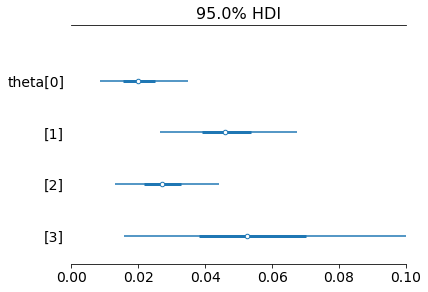

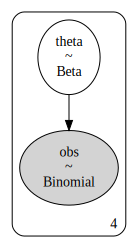

In [78]:
with model:
  pm.forestplot(trace,combined=True,hdi_prob=0.95)
  plt.xlim(0,0.1)
  plt.show()
pm.model_to_graphviz(model)


In [79]:
with model:
  print(pm.summary(trace, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.009      0.035        0.0      0.0   14640.0   
theta[1]  0.047  0.011     0.026      0.067        0.0      0.0   14558.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   12982.0   
theta[3]  0.056  0.024     0.016      0.105        0.0      0.0   11109.0   

          ess_tail  r_hat  
theta[0]    7254.0    1.0  
theta[1]    7581.0    1.0  
theta[2]    7947.0    1.0  
theta[3]    6593.0    1.0  


#効果に着目したモデリング

$$
  \alpha \sim Normal(0,10)\\
  \beta_1 \sim Normal(0,10)\\
  \beta_2 \sim Normal(0,10)\\
  \theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2 )\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 12 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # This is added back by InteractiveShellApp.init_path()


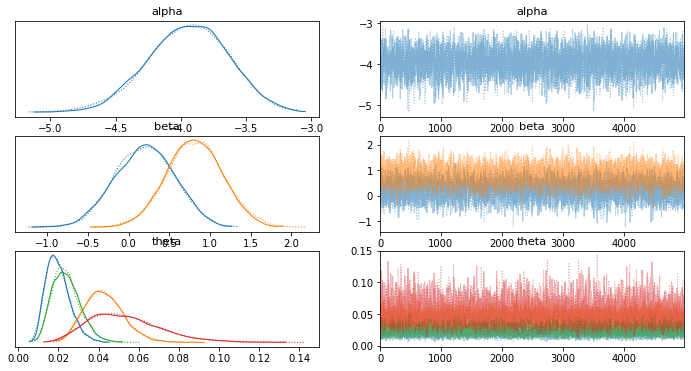

In [80]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu = 0, sigma=10)
  beta = pm.Normal('beta', mu = 0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000,chains=2)
  pm.traceplot(trace_comb, compact=True)

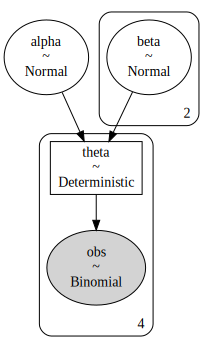

In [81]:
pm.model_to_graphviz(model_comb)

betaの事後分布



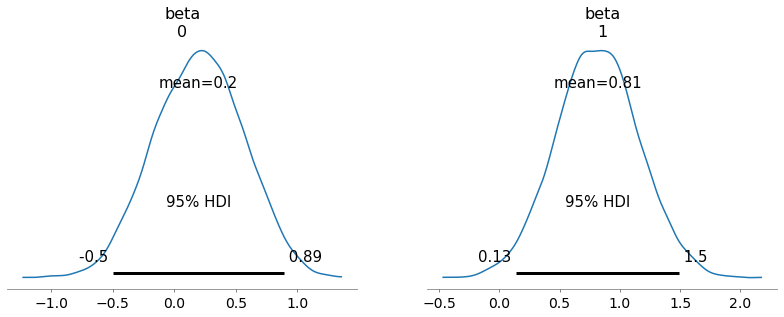

In [82]:
with model_comb:
  pm.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

betaの事後分布の正の効果

In [83]:
print((trace_comb['beta'][:, 1] > 0).mean())

0.9901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  after removing the cwd from sys.path.


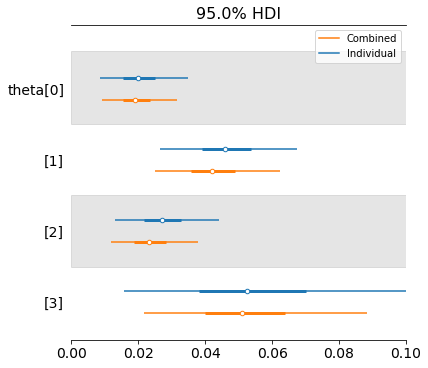

In [84]:
with pm.Model():
  pm.forestplot([trace,trace_comb], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                model_names=['Individual','Combined'])
  plt.xlim(0,0.1)
  plt.show()

In [85]:
with model:
  print(pm.summary(trace_comb, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -3.947  0.307    -4.539     -3.349      0.005    0.003    4144.0   
beta[0]   0.197  0.364    -0.501      0.891      0.006    0.004    4272.0   
beta[1]   0.814  0.346     0.135      1.492      0.005    0.004    4398.0   
theta[0]  0.020  0.006     0.009      0.031      0.000    0.000    4144.0   
theta[1]  0.043  0.010     0.025      0.062      0.000    0.000    7910.0   
theta[2]  0.024  0.007     0.012      0.038      0.000    0.000    5902.0   
theta[3]  0.053  0.018     0.022      0.088      0.000    0.000    5068.0   

          ess_tail  r_hat  
alpha       5095.0    1.0  
beta[0]     5580.0    1.0  
beta[1]     4954.0    1.0  
theta[0]    5095.0    1.0  
theta[1]    7282.0    1.0  
theta[2]    6134.0    1.0  
theta[3]    6232.0    1.0  


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


# 交互作用を加えたモデル

$$
  \alpha \sim Normal(0,10)\\
  \beta_1 \sim Normal(0,10)\\
  \beta_2 \sim Normal(0,10)\\
  \gamma \sim Normal(0,10)\\
  \theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2 + \gamma x_1 x_2)\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  if sys.path[0] == '':


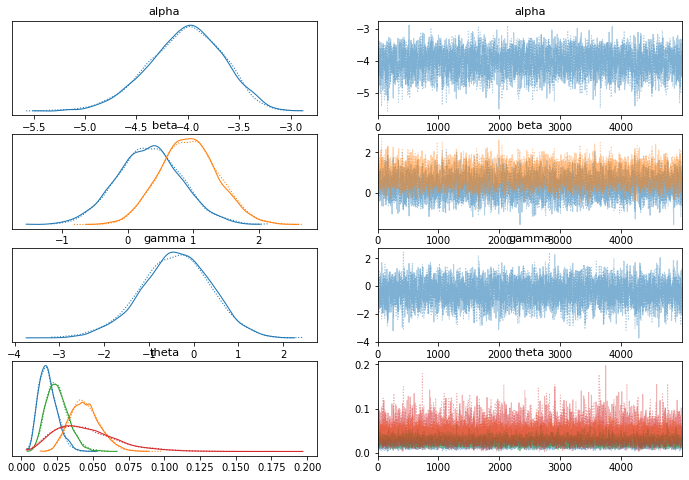

In [86]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_int:#interaction
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10,)
  comb = alpha + beta[0] * img + beta[1] *btn + gamma * img *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000,chains=2)
  pm.traceplot(trace_int, compact=True)

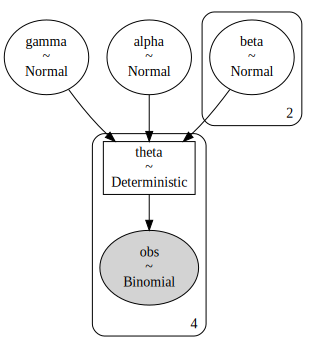

In [87]:
pm.model_to_graphviz(model_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """


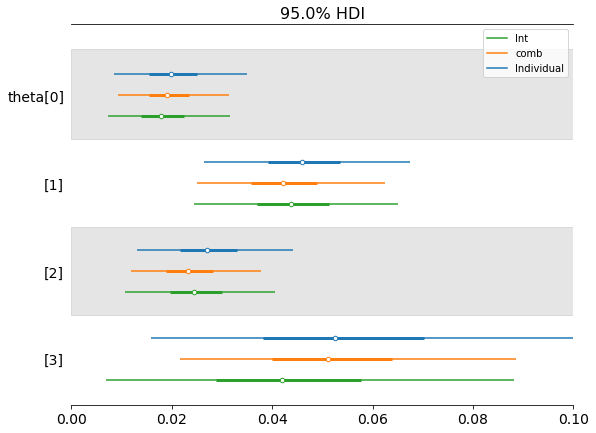

In [88]:
with pm.Model():
  pm.forestplot([trace,trace_comb,trace_int], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                figsize=(9, 7),
                model_names=['Individual','comb','Int'])
  plt.xlim(0,0.1)
  plt.show()

# データが改善されたあとのモデル

In [89]:
n_2 = [434,382,394,412]
clicks_2 = [8,17,10,8]
#clicks/n = [0.018, 0.04, 0.025, 0.019]

## 割合のみ考慮したモデル

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """


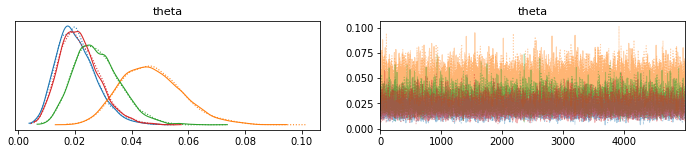

In [90]:
with pm.Model() as model_2:
  theta = pm.Beta('theta',alpha=1,beta=1,shape=len(n_2))
  obs = pm.Binomial('obs',p=theta, n=n_2, observed=clicks_2)
  trace_2 = pm.sample(5000,chains=2)
  pm.traceplot(trace_2,compact=True)

## 効果に着目したモデル

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # This is added back by InteractiveShellApp.init_path()


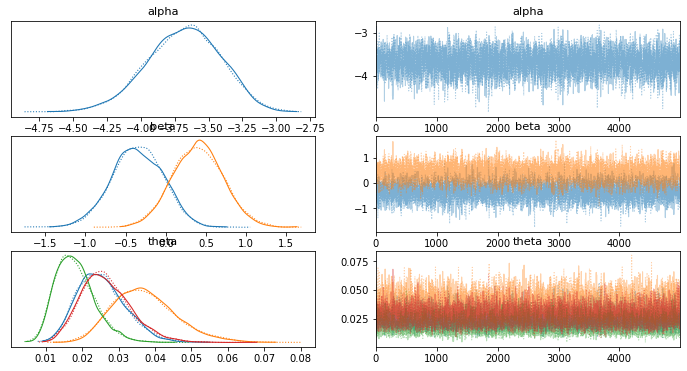

In [91]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_comb_2:
  alpha = pm.Normal('alpha', mu = 0, sigma=10)
  beta = pm.Normal('beta', mu = 0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n_2, observed=clicks_2)
  trace_comb_2 = pm.sample(5000,chains=2)
  pm.traceplot(trace_comb_2, compact=True)

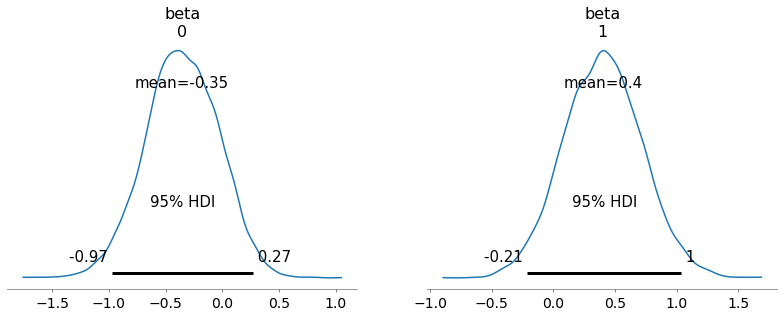

In [92]:
with model_comb:
  pm.plot_posterior(trace_comb_2, var_names=['beta'], hdi_prob=0.95)

betaの事後分布の正の効果

In [93]:
print((trace_comb_2['beta'][:, 1] > 0).mean())

0.8993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  after removing the cwd from sys.path.


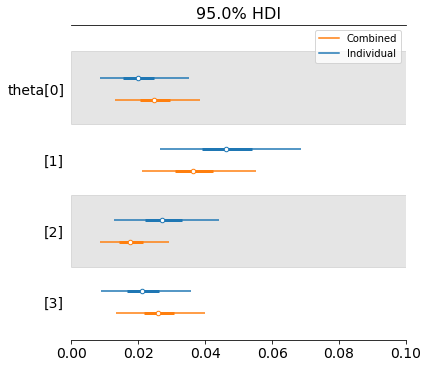

In [94]:
with pm.Model():
  pm.forestplot([trace_2,trace_comb_2], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                model_names=['Individual','Combined'])
  plt.xlim(0,0.1)
  plt.show()

In [95]:
with model:
  print(pm.summary(trace_comb_2, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -3.685  0.275    -4.212     -3.152      0.004    0.003    4700.0   
beta[0]  -0.355  0.321    -0.972      0.269      0.004    0.003    5346.0   
beta[1]   0.401  0.317    -0.211      1.034      0.004    0.003    5020.0   
theta[0]  0.025  0.007     0.013      0.038      0.000    0.000    4700.0   
theta[1]  0.037  0.009     0.021      0.055      0.000    0.000    6163.0   
theta[2]  0.018  0.005     0.009      0.029      0.000    0.000    6311.0   
theta[3]  0.026  0.007     0.013      0.040      0.000    0.000    6738.0   

          ess_tail  r_hat  
alpha       4132.0    1.0  
beta[0]     5290.0    1.0  
beta[1]     4584.0    1.0  
theta[0]    4132.0    1.0  
theta[1]    6558.0    1.0  
theta[2]    6424.0    1.0  
theta[3]    6371.0    1.0  


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


## 交互作用に着目したモデル

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  if __name__ == '__main__':


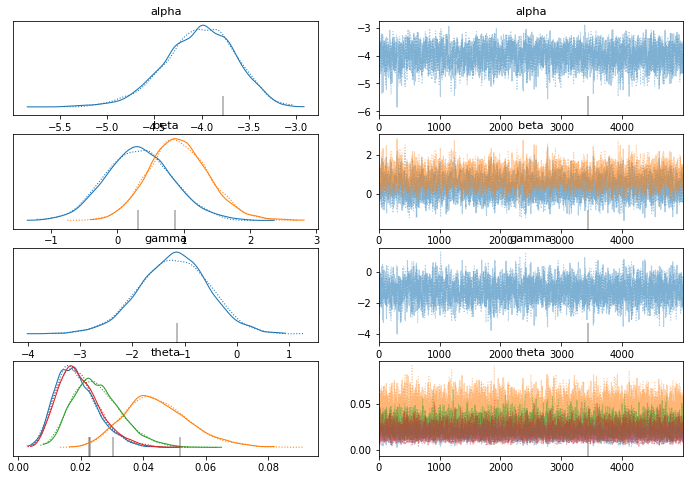

In [96]:
with pm.Model() as model_int_2:#interaction
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10,)
  comb = alpha + beta[0] * img + beta[1] *btn + gamma * img *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n_2, observed=clicks_2)
  trace_int_2 = pm.sample(5000,chains=2)
  pm.traceplot(trace_int_2, compact=True)

betaの事後分布の正の効果

In [97]:
print((trace_int_2['gamma'] < 0).mean()) 
print((trace_int_2['beta'][:, 0] > 0).mean()) 
print((trace_int_2['beta'][:, 1] > 0).mean())

0.9675
0.738
0.9836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """


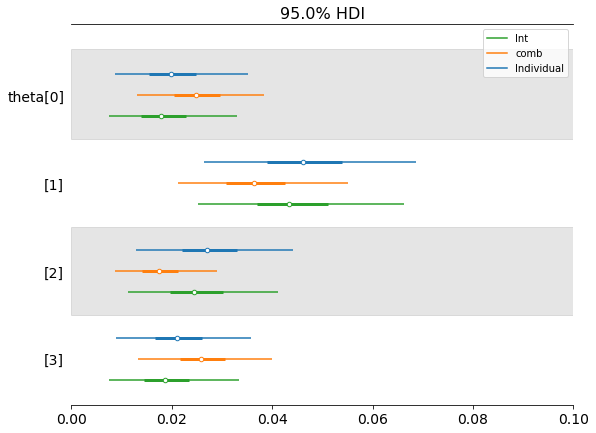

In [98]:
with pm.Model():
  pm.forestplot([trace_2,trace_comb_2,trace_int_2], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                figsize=(9, 7),
                model_names=['Individual','comb','Int'])
  plt.xlim(0,0.1)
  plt.show()